# Solve the latent variable Gaussian Graphical model using cvxpy

In [1]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import os
from os import getcwd
from os.path import dirname
from time import gmtime, strftime
import scipy as sp
import cvxpy as cvx
from sklearn.linear_model import lars_path
%matplotlib inline 
import sys

cwd = getcwd()
dir_root = dirname(cwd)
filepath = os.path.join(dir_root, 'src')
sys.path.append(filepath) #('/home/tianpei/Dropbox/Codes/Python/LatNet/src/')
print(filepath)
%load_ext Cython

/home/tianpei/Dropbox/Codes/Python/LatNet/src


In [2]:
from latent_signal_network import latent_signal_network as lsn 

In [3]:
savefigure = False
seed = 1000
choice = 'grid'
d = 100 # larger than the size of nodes

[(4, 0), (1, 2), (5, 5), (0, 6), (4, 4), (6, 3), (5, 6), (3, 6), (0, 4), (3, 3), (5, 3), (4, 1), (1, 1), (6, 4), (3, 2), (0, 0), (5, 0), (4, 5), (2, 2), (6, 0), (1, 4), (0, 5), (4, 2), (1, 0), (6, 5), (3, 5), (0, 1), (4, 6), (3, 4), (6, 1)]


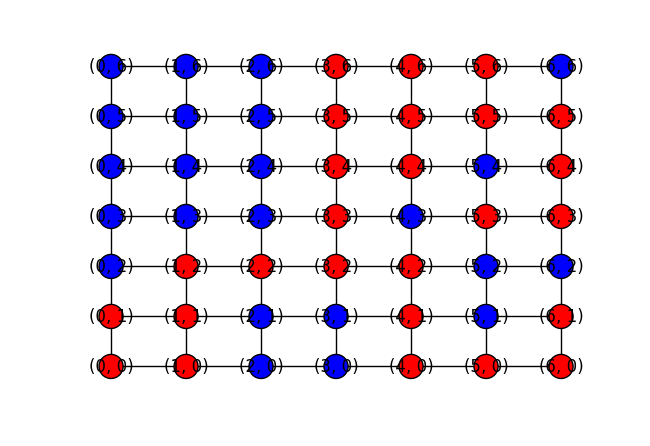

In [4]:
if choice == 'newman':
    size = 20
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['k-NN'] = 2
    LSN = lsn(size, prob, option)
    G0, G1, node_lists, node_sets = LSN.graph_build(size=size, prob=prob, option=option, subset=np.arange(17),save_fig=savefigure)
elif choice == 'partition':
    size = [20, 20]
    prob = [0.8, 0.1]
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['cutoff_freq'] = 12
    LSN = lsn(size, prob, option)
    G0, G1, node_lists, node_sets = LSN.graph_build(size=size, prob=prob, option=option, subset=np.arange(17), save_fig=savefigure)
elif choice == 'grid':
    size = [7, 7]
    prob = 0.6
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0, G1, node_lists, node_sets = LSN.graph_build(size=size, prob=prob, option=option, subset=10+np.arange(30), save_fig=savefigure)
elif choice == 'binomial':
    size = 30
    prob = 0.195

    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0, G1, node_lists, node_sets = LSN.graph_build(size=size, prob=prob, option=option, subset=np.arange(17), save_fig=savefigure)
    
elif choice == 'tree':
    size = 20
    gamma = 3
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'gamma': gamma ,'model': choice}
    option['cutoff_freq'] = 10
    LSN = lsn(size, prob, option)
    G0, G1, node_lists, node_sets = LSN.graph_build(size=size, prob=prob, option=option, subset=np.arange(17), save_fig=savefigure)
    
elif choice == 'balanced_tree':
    size = 30
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['r'] = 2
    option['h'] = 4
    LSN = lsn(size, prob, option)
    G0, G1, node_lists, node_sets = LSN.graph_build(size=size, prob=prob, option=option, subset=np.arange(17),save_fig=savefigure)
    
elif choice == 'bipartite_binomial':
    size = [20, 10]
    prob =  0.4
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0, G1, node_lists, node_sets = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
    
elif choice == 'bipartite_uniform':
    size = [20, 20]
    prob = 0.17
    num_edges = prob*size[0]*size[1]
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['num_edges'] = num_edges
    LSN = lsn(size, prob, option)
    G0, G1, node_lists, node_sets = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)


In [5]:
n1 = len(G0)
n2 = len(G1)
print("size of total graph %d, size of sub-network %d" % (n1, n2))

size of total graph 49, size of sub-network 26


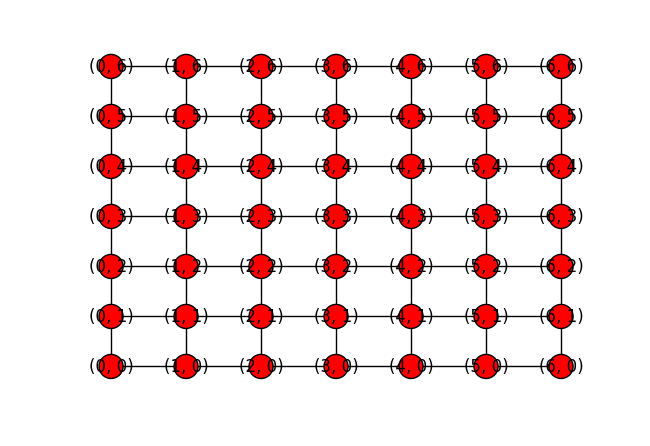

In [6]:
G0 = LSN.graph_build(size=size, prob=prob, option=option,save_fig=savefigure)

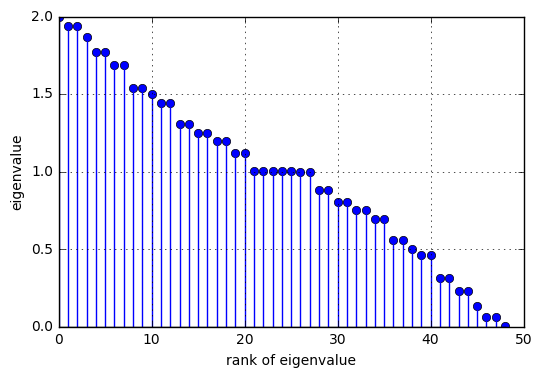

In [7]:
#Plot the eigenvalue of Laplacian matrix
Laplacian = nx.normalized_laplacian_matrix(G0, weight=None).todense()
#Sigma, U = np.linalg.eigh(abs(adjMat))
Sigma, U = np.linalg.eigh(Laplacian)

index_sig = np.argsort(Sigma)
Sigma = Sigma[index_sig[::-1]]
U = U[:,index_sig[::-1]]

fig3 =plt.figure(3)
ax = plt.gca()
(markerline, stemlines, baseline) = plt.stem(np.arange(len(Sigma)), Sigma, 'b', basefmt='k-')
#plt.plot(np.arange(len(Sigma)), np.ones((len(Sigma, ))), 'r')
plt.xlabel('rank of eigenvalue')
plt.ylabel('eigenvalue')
ax.grid(True)
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_laplacian.eps"
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_adjMat.eps"
if savefigure : fig3.savefig(filename)

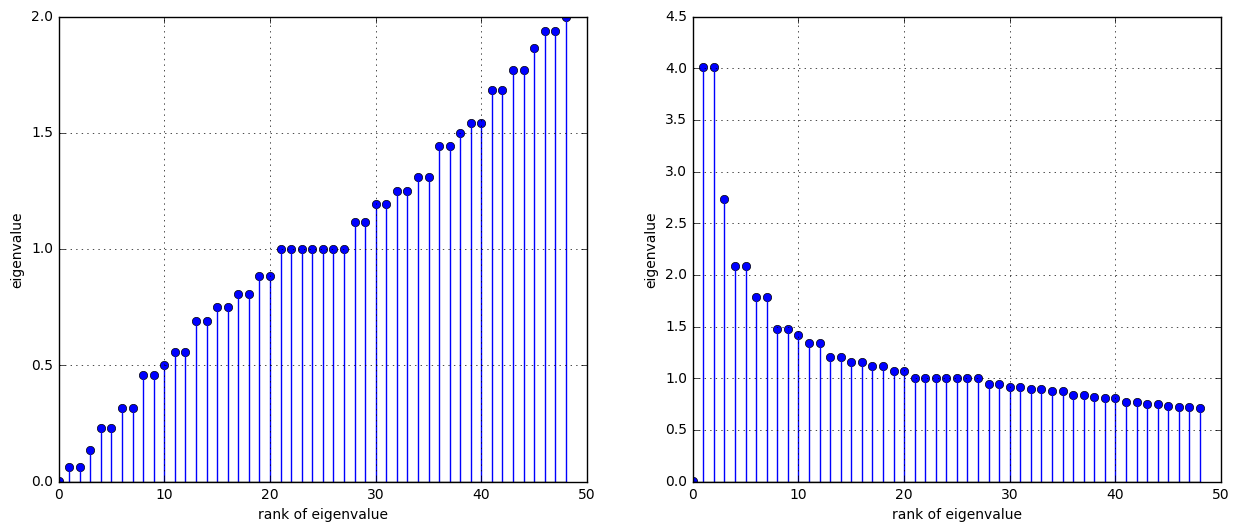

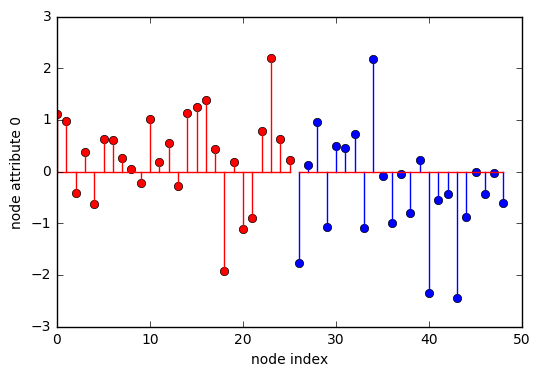

In [8]:
Tmax = 1
option_sig = {}
option_sig['mat'] = 'laplacian_matrix' #'adjacency_matrix'
choice2 = 'inverse_sqrt'
option_sig['method'] = choice2
if choice2 == 'l1_threshold':
    option_sig['threshold'] = 0.5
elif choice2 == 'polynomial':
    degree_val = np.array(list(G0.degree().values()))
    bias = 1/np.sqrt(np.mean(degree_val))
    option_sig['coeffs'] = [bias, -1, 1, 1/3]
elif choice2 == 'inverse_poly':
    degree_val = np.array(list(G0.degree().values()))
    bias = 1/np.sqrt(np.mean(degree_val))
    option_sig['coeffs'] = [bias, -1, 1, 1/3]    
elif choice2 == 'rescale':
    option_sig['weights'] = np.random.rand((len(G0),))
elif choice2 == 'sigmoid_theshold':
    option_sig['rate'] = 1
    option_sig['shift'] = 0.5
    option_sig['bias'] = 0
elif choice2 == 'inverse_sqrt':
    option_sig['eps'] = 0
    
     
    
G0_node, X0, _= LSN.smooth_gsignal_filter(G0, option_sig, sigma=1, seed=10, add_noise=False, show_plot=True, save_fig=savefigure)
X0 -= np.mean(X0, axis=0)
X0 /= X0.std(axis=0)

#X_mean = np.mean(X0, axis=1)
#G0_node, X0, hist_tv = LSN.smooth_gsignal_generate(G0, T=Tmax, sigma=10, alpha=0.2, seed=10, add_noise=False, overwrite=True)
fig1 = plt.figure(1)
(markerline, stemlines, baseline) = plt.stem(np.arange(len(node_sets[0])),X0[0:len(node_sets[0]),0], 'r')
plt.setp(markerline, 'markerfacecolor', 'r')
(markerline, stemlines, baseline) = plt.stem(len(node_sets[0])+np.arange(len(node_sets[1])),X0[len(node_sets[0]):len(G0),0], 'b')
plt.setp(markerline, 'markerfacecolor', 'b')

plt.xlabel('node index')
plt.ylabel('node attribute 0')
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_node_fea0.eps"
if savefigure : fig1.savefig(filename)

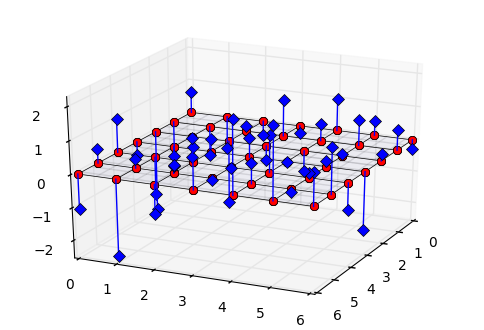

In [9]:
if choice == 'newman' or choice == 'tree':
    pos=nx.circular_layout(G0, dim=2, scale=1.0, center=None)
elif choice == 'grid':
    pos=dict(zip(G0.nodes(), [np.asarray(u) for u in G0.nodes()]))
elif 'bipartite' in choice:
    pos=nx.nx_pydot.graphviz_layout(G0, prog='dot')
else:
    pos=nx.nx_pydot.graphviz_layout(G0)
    
X0_2, nodeIdx = LSN.get_node_attributes(G0_node)
pos_coordinate = np.array([[pos[it['node']][0], pos[it['node']][1]] for it in nodeIdx])

edge_list = LSN.get_edgelist(G0_node)

view_angle = [25, 25] #[25, 180]
LSN.plot_node_3d(pos_coordinate, edge_list, X0_2, view_angle=view_angle, nodeIdx=nodeIdx, save_fig=savefigure)

In [10]:
observed_idx = [item['loc'] for item in nodeIdx if item['node'] in node_sets[0]]
hidden_idx = [item['loc'] for item in nodeIdx if item['node'] in node_sets[1]]
X_o = X0[observed_idx,:]
X_h = X0[hidden_idx,:]
mask = np.ones((len(G0), len(G0)))
mask[np.ix_(observed_idx, observed_idx)] = np.ones((len(node_sets[0]), len(node_sets[0])))

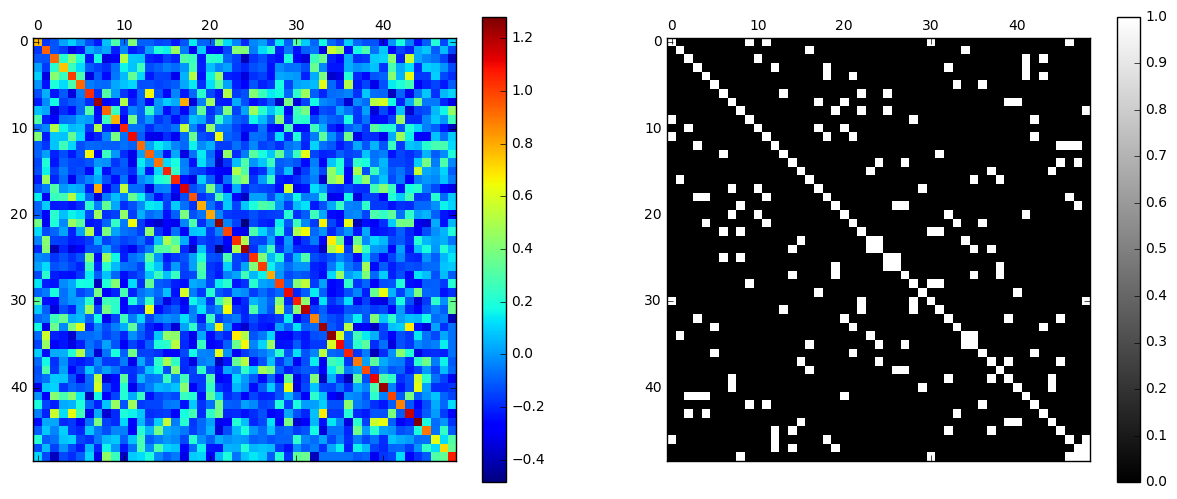

In [11]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(np.cov(X0))
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
cax = ax.matshow(sp.sign(abs((Laplacian))), cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()

## Glasso for full data

In [12]:
from graphical_lasso import sparse_inv_cov_glasso 
from latent_signal_network import graph_precision_recall_curve, glasso_nonzero_ratio, graph_comparison_norm
from latent_signal_network import edge_list_convert, jaccard_sim

In [13]:
alpha = 0.3
covariance_all, precision_all = sparse_inv_cov_glasso(X0, alpha=alpha, max_iter = 100)

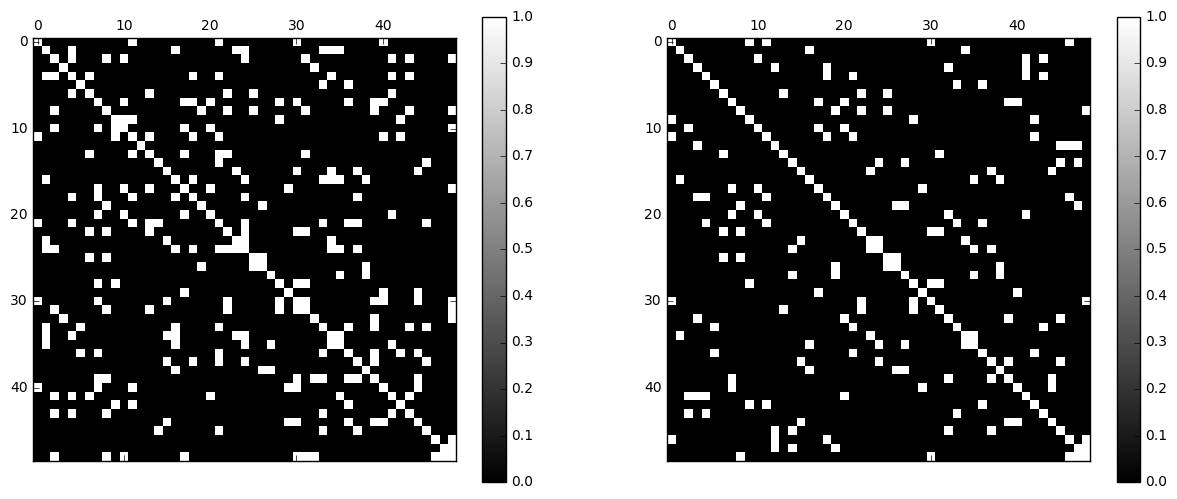

In [14]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(sp.sign(abs(precision_all)), cmap=plt.cm.gray)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
cax = ax.matshow(sp.sign(abs((Laplacian))), cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian.eps"
if savefigure : fig2.savefig(filename)

In [15]:
glasso_nonzero_ratio(precision_all)

(178.0, 0.15136054421768708)

In [16]:
glasso_nonzero_ratio(Laplacian)

(133.0, 0.1130952380952381)

In [17]:
n_iters = 100

In [18]:
#n_iters = 20
precision_curve = []
recall_curve = []
avg_precision = []
auc_array = []
norm_diff = []
jaccard_sim_list = []
alpha_array = np.linspace(4e-2, 1, n_iters)
for i, alphas in enumerate(alpha_array):
    _, precision_all_tmp = sparse_inv_cov_glasso(X0, alpha=alphas, max_iter = 100)
    #print(precision_all.shape)
    precision_curve_temp, recall_curve_temp, avg_precision_temp, auc_temp = graph_precision_recall_curve(Laplacian, precision_all_tmp)
    norm_diff.append(graph_comparison_norm(Laplacian, precision_all_tmp))
    jaccard_sim_list.append(jaccard_sim(edge_list_convert(Laplacian), edge_list_convert(precision_all_tmp)))
    precision_curve.append(precision_curve_temp)
    recall_curve.append(recall_curve_temp)
    avg_precision.append(avg_precision_temp)
    auc_array.append(auc_temp)

The algorithm did not coverge. Try increasing the max number of iterations.
The algorithm did not coverge. Try increasing the max number of iterations.
The algorithm did not coverge. Try increasing the max number of iterations.
The algorithm did not coverge. Try increasing the max number of iterations.
The algorithm did not coverge. Try increasing the max number of iterations.
The algorithm did not coverge. Try increasing the max number of iterations.


In [19]:
#from itertools import cycle
#fig2 = plt.figure(2, figsize=(10,8))
#colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
#lw = 2
#for i, color in zip(range(n_iters), colors):
#    plt.plot(recall_curve[i], precision_curve[i], color=color, lw=lw, 
#             label='alpha = %.2f, AP = %.2f' % (alpha_array[i], avg_precision[i]))

#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.legend(loc="lower left")
#plt.show()  
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_PRcurve_all.eps"
#if savefigure : fig2.savefig(filename)

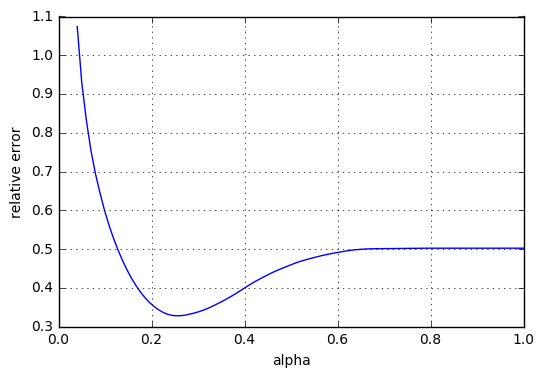

In [20]:
fig2 = plt.figure(2)
plt.plot(alpha_array, norm_diff, 'b')
plt.grid()
plt.xlabel('alpha')
plt.ylabel('relative error')
plt.show()  
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_norm_diff.eps"
if savefigure : fig2.savefig(filename)

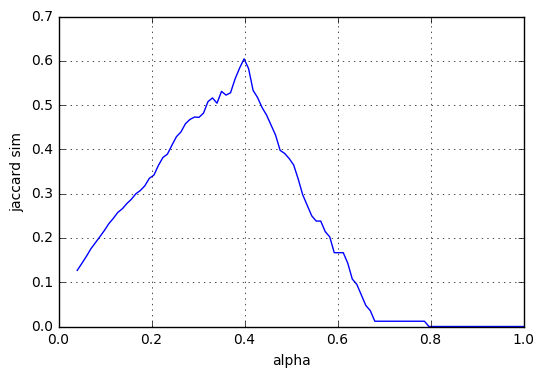

In [21]:
fig2 = plt.figure(2)
plt.plot(alpha_array, jaccard_sim_list, 'b')
plt.grid()
plt.xlabel('alpha')
plt.ylabel('jaccard sim')
plt.show()  
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_norm_diff.eps"
#if savefigure : fig2.savefig(filename)

## gLasso over marginal covariance

In [22]:
alpha_2 = 2.5e-1
covariance_margin_o, precision_margin_o = sparse_inv_cov_glasso(X_o, alpha=alpha_2, max_iter = 100)

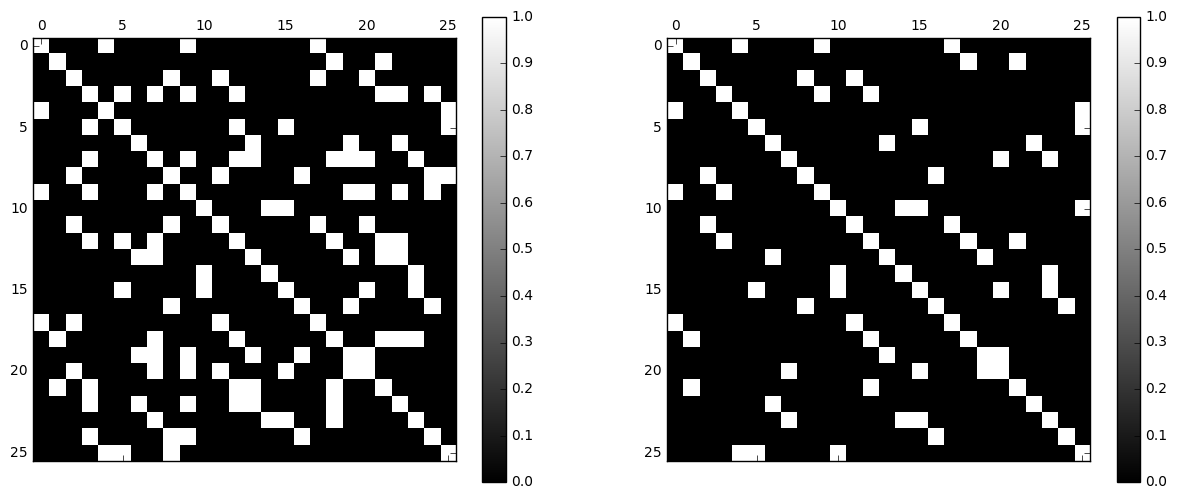

In [23]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(sp.sign(abs(precision_margin_o)), cmap=plt.cm.gray)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
cax = ax.matshow(sp.sign(abs((Laplacian[np.ix_(observed_idx, observed_idx)]))), cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian_marginal.eps"
if savefigure : fig2.savefig(filename)

In [24]:
#n_iters = 20
precision_curve = []
recall_curve = []
avg_precision = []
auc_array = []
norm_diff = []
jaccard_sim_list = []
alpha_array = np.linspace(1e-1, 1, n_iters)
for i, alphas in enumerate(alpha_array):
    covariance_marginal, precision_marginal = sparse_inv_cov_glasso(X_o, alpha=alphas, max_iter = 100)
    precision_curve_temp, recall_curve_temp, avg_precision_temp, auc_temp = \
                  graph_precision_recall_curve(Laplacian[np.ix_(observed_idx, observed_idx)], precision_marginal)
    norm_diff.append(graph_comparison_norm(Laplacian[np.ix_(observed_idx, observed_idx)], precision_marginal))
    jaccard_sim_list.append(jaccard_sim(edge_list_convert(Laplacian[np.ix_(observed_idx, observed_idx)]), \
                                        edge_list_convert(precision_marginal)))
    precision_curve.append(precision_curve_temp)
    recall_curve.append(recall_curve_temp)
    avg_precision.append(avg_precision_temp)
    auc_array.append(auc_temp)

In [25]:
#from itertools import cycle
#fig2 = plt.figure(2, figsize=(10,8))
#colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
#lw = 2
#for i, color in zip(range(n_iters), colors):
#    plt.plot(recall_curve[i], precision_curve[i], color=color, lw=lw, 
#             label='alpha = %.2f, AP = %.2f' % (alpha_array[i], avg_precision[i]))

#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.legend(loc="lower left")
#plt.show()  
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_PRcurve_marginal.eps"
#if savefigure : fig2.savefig(filename)

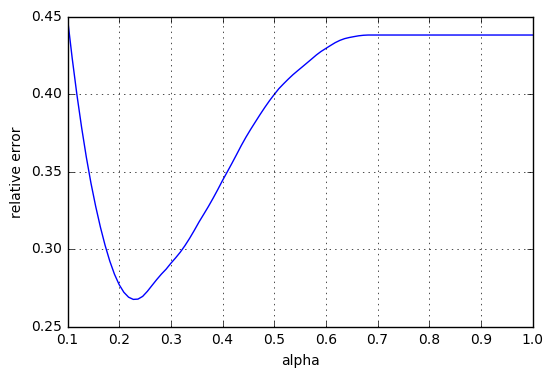

In [26]:
fig2 = plt.figure(2)
plt.plot(alpha_array, norm_diff, 'b')
plt.grid()
plt.xlabel('alpha')
plt.ylabel('relative error')
plt.show()  
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_norm_diff_marginal.eps"
if savefigure : fig2.savefig(filename)

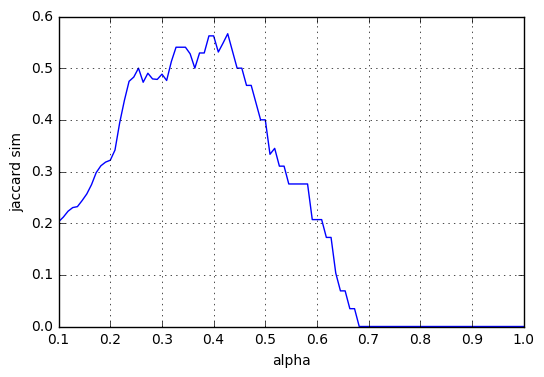

In [27]:
fig2 = plt.figure(2)
plt.plot(alpha_array, jaccard_sim_list, 'b')
plt.grid()
plt.xlabel('alpha')
plt.ylabel('jaccard sim')
plt.show()  
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_norm_diff.eps"
#if savefigure : fig2.savefig(filename)

##  Find generalized Laplaican matrix $Q$

\begin{eqnarray}
 \mathbf{Q}^{*}&= \arg\min_{\mathbf{Q}} -\frac{m}{2}\log\det\left(\mathbf{Q}\right)+ \frac{m}{2}\text{tr}\left(\widehat{\mathbf{\Sigma} }_{o}\mathbf{Q}\right)   \\
&\phantom{=}\text{s.t. }\quad \mathbf{Q}_{i,j} \le 0, i\neq j \nonumber\\
&\phantom{===}\; \mathbf{Q}\succeq \mathbf{0}  \nonumber
\end{eqnarray}

In [28]:
from generalized_Laplacian_estimate import generalized_Laplacian_estimate
import pywt

In [29]:
gen_Laplacian = generalized_Laplacian_estimate(X0, max_iter = 100)

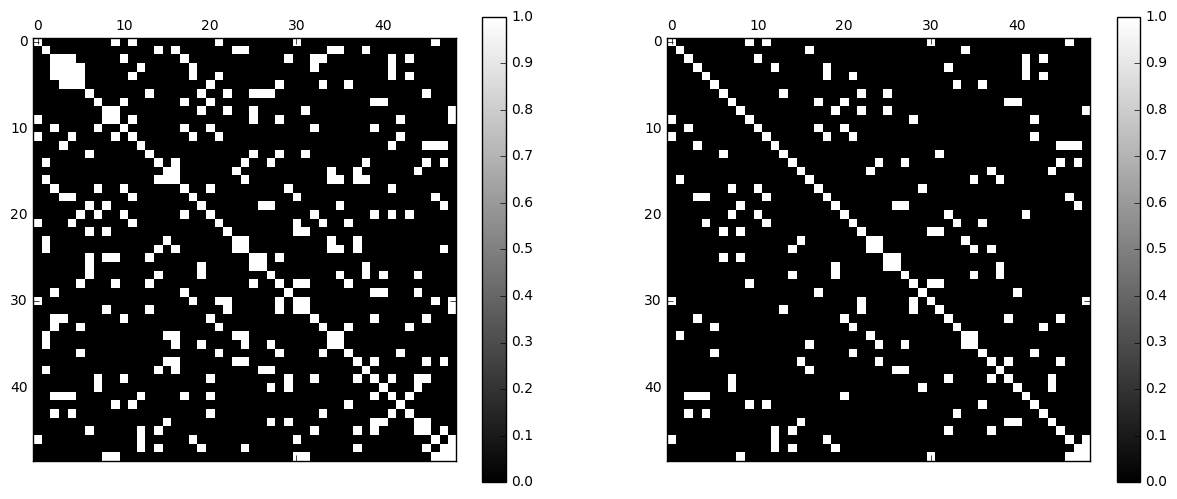

In [30]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(sp.sign(abs(gen_Laplacian)), cmap=plt.cm.gray)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
cax = ax.matshow(sp.sign(abs((Laplacian+option_sig['eps']*np.eye(gen_Laplacian.shape[0])))), cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian_genLap.eps"
if savefigure : fig2.savefig(filename)

##  Use ADMM to learn the latent variable sparse inverse covariance estimation

From
\begin{eqnarray}
 (\mathbf{S}^{*} , \mathbf{L}^{*})&= \arg\min_{\mathbf{L},\; \;\mathbf{S}} -\frac{m}{2}\log\det\left(\mathbf{S} - \mathbf{L}\right)+ \frac{m}{2}\text{tr}\left(\widehat{\mathbf{\Sigma} }_{o}\left( \mathbf{S} - \mathbf{L}\right)\right) + \alpha_{m} \left(\lambda \|\mathbf{S}\|_{1}  + \|\mathbf{L}\|_{*}\right)  \\
&\phantom{=}\text{s.t. }\quad \mathbf{S} - \mathbf{L}\succeq \mathbf{0} \nonumber\\
&\phantom{===}\; \mathbf{L}\succeq \mathbf{0}  \nonumber
\end{eqnarray}

we can instead solve the problem
\begin{eqnarray}
 (\mathbf{R}^*, \mathbf{S}^{*} , \mathbf{L}^{*})&= \arg\min_{\mathbf{L},\; \mathbf{R}, \; \mathbf{S}} -\frac{m}{2}\log\det\left(\mathbf{R}\right)+ \frac{m}{2}\text{tr}\left(\widehat{\mathbf{\Sigma} }_{o}\mathbf{R}\right) + \alpha_{m} \|\mathbf{S}\|_{1}  + \gamma_{m} \|\mathbf{L}\|_{*}  \\
&\phantom{=}\text{s.t. }\quad \mathbf{R} - \mathbf{S} + \mathbf{L} = \mathbf{0} \nonumber\\
&\phantom{===}\; \mathbf{R}\succ \mathbf{0}  \nonumber\\
&\phantom{===}\; \mathbf{L}\succeq \mathbf{0}  \nonumber
\end{eqnarray}
or with concensus constraint
\begin{eqnarray}
 (\mathbf{R}^*, \mathbf{S}^{*} , \mathbf{L}^{*})&= \arg\min_{\mathbf{L},\; \mathbf{R}, \; \mathbf{S},\; \mathbf{L}',\; \mathbf{R}', \; \mathbf{S}'} -\frac{m}{2}\log\det\left(\mathbf{R}\right)+ \frac{m}{2}\text{tr}\left(\widehat{\mathbf{\Sigma} }_{o}\mathbf{R}\right) + \alpha_{m} \|\mathbf{S}\|_{1}  + \gamma_{m} \|\mathbf{L}\|_{*} + \mathbf{1}\left(\mathbf{R}' - \mathbf{S}' + \mathbf{L}' = 0\right)  \\
&\phantom{=}\text{s.t. }\quad \mathbf{R} - \mathbf{S} + \mathbf{L} = \mathbf{R}' - \mathbf{S}' + \mathbf{L}' \nonumber\\
&\phantom{===}\; \mathbf{R}\succ \mathbf{0}  \nonumber\\
&\phantom{===}\; \mathbf{L}\succeq \mathbf{0}  \nonumber
\end{eqnarray}



In [31]:
from latent_graphical_lasso import latent_variable_gmm_admm

/home/tianpei/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
alpha3 = 0.13
_, sparse_admm_o, low_rank_admm_o, _, constr_hists, diff_pre_hists = latent_variable_gmm_admm(X_o, alpha=alpha3, gamma=0.3, 
                                                             mu=10, max_iter=1000, threshold=1e-3, 
                                                             verbose=False, return_costs=True)

optimal solution found.


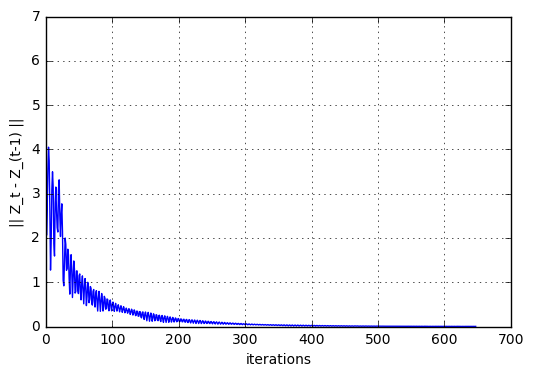

In [33]:
fig2 = plt.figure(2)
plt.plot(np.arange(len(diff_pre_hists)), diff_pre_hists, 'b')
plt.grid()
plt.xlabel('iterations')
plt.ylabel('|| Z_t - Z_(t-1) ||')
plt.show()  
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_norm_conveg_diff.eps"
if savefigure : fig2.savefig(filename)

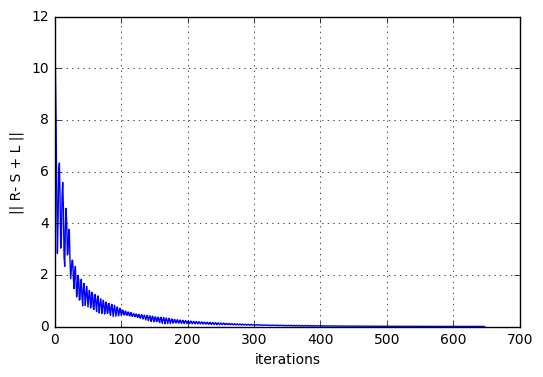

In [34]:
fig2 = plt.figure(2)
plt.plot(np.arange(len(constr_hists)), constr_hists, 'b')
plt.grid()
plt.xlabel('iterations')
plt.ylabel('|| R- S + L ||')
plt.show()  
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_norm_conveg_constraint.eps"
if savefigure : fig2.savefig(filename)

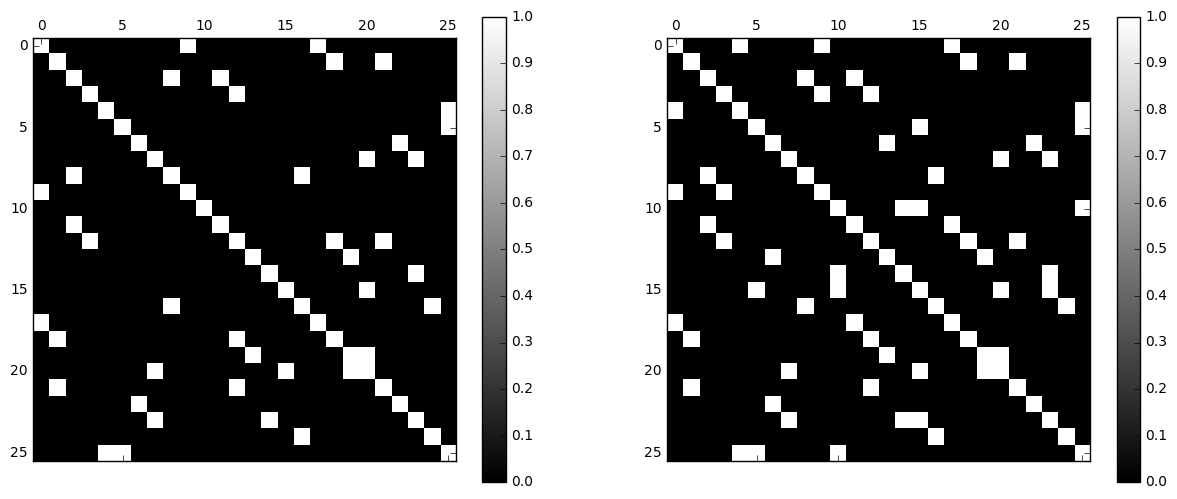

In [35]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(sp.sign(abs(sparse_admm_o)), cmap=plt.cm.gray)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
cax = ax.matshow(sp.sign(abs((Laplacian[np.ix_(observed_idx, observed_idx)]))), cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian_cvx.eps"
if savefigure : fig2.savefig(filename)

In [36]:
from latent_signal_network import graph_precision_recall_curve, glasso_nonzero_ratio, graph_comparison_norm
#n_iters = 20
precision_curve = []
recall_curve = []
avg_precision = []
auc_array = []
norm_diff = []
jaccard_sim_list = []
alpha_array = np.linspace(1e-2, 5e-1, n_iters)
for i, alphas in enumerate(alpha_array):
    _, sparse_admm_tmp, low_rank_admm_tmp = latent_variable_gmm_admm(X_o, alpha=alphas, gamma=0.3, 
                                                             mu=10, threshold=1e-3)
    #print(precision_all.shape)
    precision_curve_temp, recall_curve_temp, avg_precision_temp, auc_temp = graph_precision_recall_curve(Laplacian[np.ix_(observed_idx, observed_idx)], sparse_admm_tmp)
    norm_diff.append(graph_comparison_norm(Laplacian[np.ix_(observed_idx, observed_idx)], sparse_admm_tmp))
    jaccard_sim_list.append(jaccard_sim(edge_list_convert(Laplacian[np.ix_(observed_idx, observed_idx)]), \
                                        edge_list_convert(sparse_admm_tmp)))
    precision_curve.append(precision_curve_temp)
    recall_curve.append(recall_curve_temp)
    avg_precision.append(avg_precision_temp)
    auc_array.append(auc_temp)

optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution found.
optimal solution

In [37]:
#from itertools import cycle
#fig2 = plt.figure(2, figsize=(10,8))
#colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
#lw = 2
#for i, color in zip(range(n_iters), colors):
#    plt.plot(recall_curve[i], precision_curve[i], color=color, lw=lw, 
#             label='alpha = %.2f, AP = %.2f' % (alpha_array[i], avg_precision[i]))

#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.legend(loc="lower left")
#plt.show()  
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_PRcurve_admm.eps"
#if savefigure : fig2.savefig(filename)

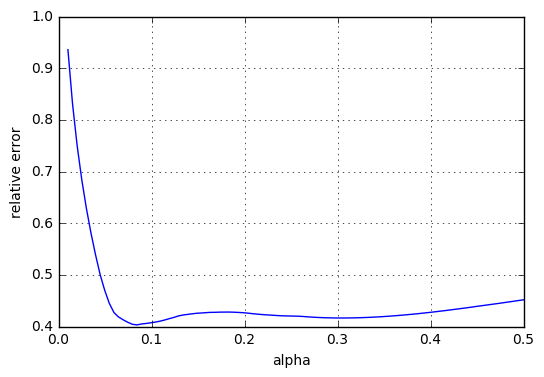

In [38]:
fig2 = plt.figure(2)
plt.plot(alpha_array, norm_diff, 'b')
plt.grid()
plt.xlabel('alpha')
plt.ylabel('relative error')
plt.show()  
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_norm_diff.eps"
if savefigure : fig2.savefig(filename)

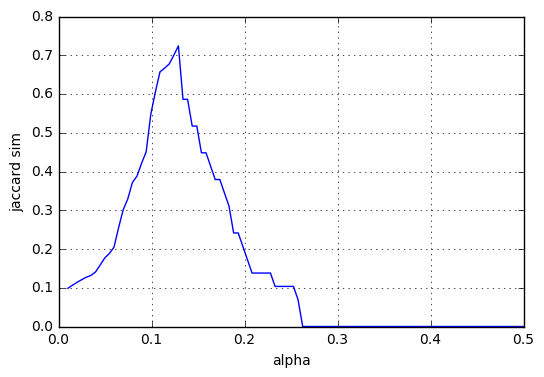

In [39]:
fig2 = plt.figure(2)
plt.plot(alpha_array, jaccard_sim_list, 'b')
plt.grid()
plt.xlabel('alpha')
plt.ylabel('jaccard sim')
plt.show()  
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_norm_diff.eps"
#if savefigure : fig2.savefig(filename)

##  Use EM-glasso to learn the latent variable sparse inverse covariance estimation

For $t = 1, 2, \ldots, $
 1. M-Step:  find sparse inverse covariance for joint (observerd, latent)
 
    \begin{eqnarray}
     \widehat{\mathbf{\Theta}}_{(o,h),t}^{*} &= \arg\min_{\mathbf{\Theta}} -\frac{m}{2}\log\det\left(\mathbf{\Theta}\right)+ \frac{m}{2}\text{tr}\left(\widehat{\mathbf{\Sigma} }_{(o,h), (t-1)}\left( \mathbf{\Theta}\right)\right) + \alpha_{m}  \|\mathbf{P} \odot \mathbf{\Theta}\|_{1} \\
     &\phantom{=}\text{s.t. }\quad \mathbf{\Theta}\succeq \mathbf{0}  \nonumber
    \end{eqnarray}
    where $\odot$ is piecewise product. and 
    \begin{align}
    \mathbf{P} &= \left[
    \begin{array}{cc}
    \mathbf{J}_{o} & \mathbf{0}_{o,h}\\
    \mathbf{0}_{h,o} & \mathbf{0}_{h}
    \end{array}
    \right]
    \end{align} for $\mathbf{J} \in \mathbb{R}^{o\times o}$ all 1s matrix.
    
 2. E-Step:  find the expected empirical covariance over joint (observed, latent) variables given observed variables
     
     \begin{align}
       \widehat{\mathbf{\Sigma}}_{(o,h), t} \big| \left(\mathbf{\Sigma}_{o}, \widehat{\mathbf{\Theta}}_{(o,h),t}^{*}\right) &= 
       \left[
        \begin{array}{cc}
        \mathbf{\Sigma}_{o} & -\mathbf{\Sigma}_{o}\widehat{\mathbf{\Theta}}_{o,h,t}\\
        -\widehat{\mathbf{\Theta}}_{h,o,t}\mathbf{\Sigma}_{o} & \left(\mathbf{\Sigma}_{h}\right)^{-1} + 
        \widehat{\mathbf{\Theta}}_{h,o,t}\mathbf{\Sigma}_{o}\widehat{\mathbf{\Theta}}_{o,h,t}
        \end{array}
       \right]
     \end{align}
     
     In implementation, we let $\mathbf{\Sigma}_{h} = \mathbf{I}.$

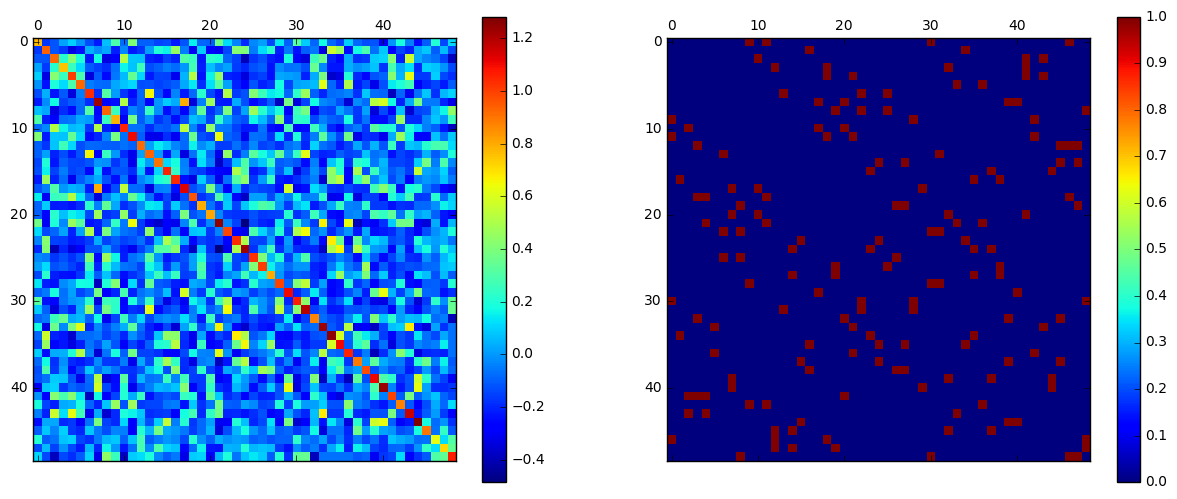

In [40]:
n, m = X_o.shape
emp_cov = np.cov(X_o)

lambda_s = 1
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(np.cov(X0))
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
adjMatSparse =  nx.adjacency_matrix(G0)
adjMat = adjMatSparse.todense()
cax = ax.matshow(adjMat)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_adjmat.eps"
if savefigure : fig2.savefig(filename)

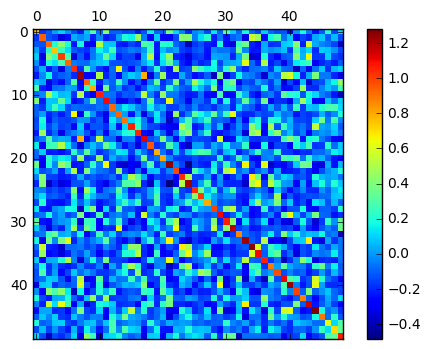

In [41]:
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(np.cov(X0))
fig2.colorbar(cax)


plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_all.eps"
if savefigure : fig2.savefig(filename)

In [42]:
from latent_graphical_lasso import latent_variable_glasso_data

In [43]:
alpha =3.5e-1
Laplacian_perm = np.zeros((len(G0), len(G0)))
Laplacian_perm[np.ix_(np.arange(len(observed_idx)),np.arange(len(observed_idx)))] \
           = Laplacian[np.ix_(observed_idx,observed_idx)]
Laplacian_perm[np.ix_(np.arange(len(observed_idx)),len(observed_idx)+np.arange(len(hidden_idx)))] \
           = Laplacian[np.ix_(observed_idx,hidden_idx)]
Laplacian_perm[np.ix_(len(observed_idx)+np.arange(len(hidden_idx)), np.arange(len(observed_idx)))] \
           = Laplacian[np.ix_(hidden_idx, observed_idx)]    
Laplacian_perm[np.ix_(len(observed_idx)+np.arange(len(hidden_idx)), len(observed_idx)+np.arange(len(hidden_idx)))] \
           = Laplacian[np.ix_(hidden_idx, hidden_idx)]  

In [44]:
    
mask = np.ones((len(G0), len(G0))) - np.sign(abs(Laplacian_perm))
#mask = np.ones((len(G0), len(G0)))
mask[np.ix_(np.arange(len(observed_idx)),np.arange(len(observed_idx)))] = np.ones((len(observed_idx), len(observed_idx)))
#mask[np.ix_(hidden_idx, observed_idx)] = np.ones(( len(hidden_idx), len(observed_idx)))
#mask[np.ix_(hidden_idx,hidden_idx)] = np.zeros((len(hidden_idx), len(hidden_idx)))
#Theta_h = np.ascontiguousarray(Laplacian[np.ix_(hidden_idx,hidden_idx)]).copy()

covariance_em_o, precision_em_o, _, prec_all_list_em, dsol_list = \
                    latent_variable_glasso_data(X_o, X_h, alpha=alpha, mask=mask, 
                                                max_iter_out = 800, verbose=False,
                                                threshold=1e-3, return_hists=True)

  0%|          | 0/800 [00:00<?, ?it/s]


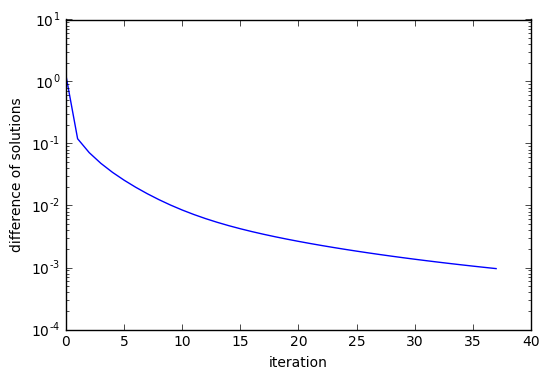

In [45]:
plt.semilogy(dsol_list)
plt.xlabel('iteration')
plt.ylabel('difference of solutions')
plt.show()

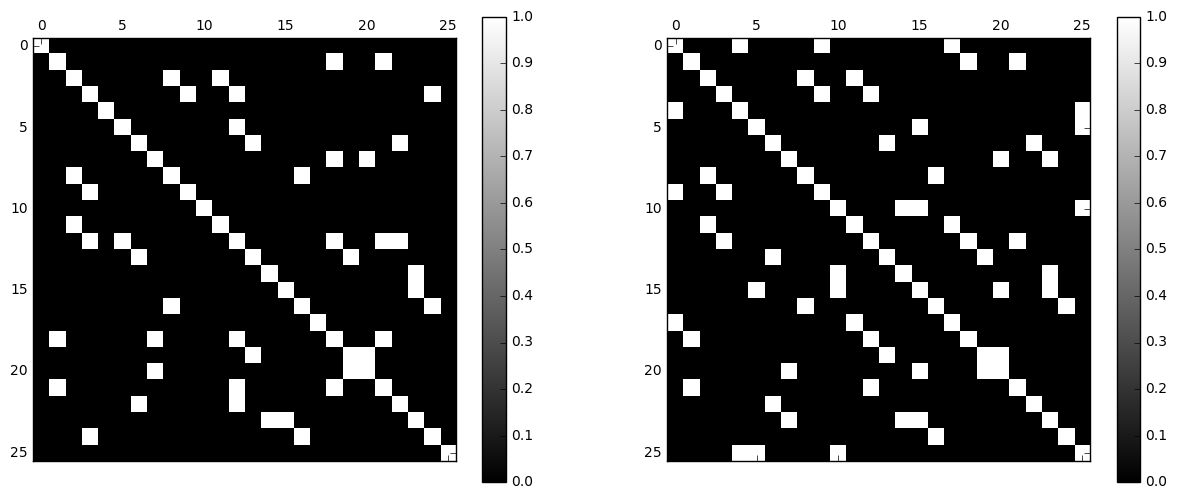

In [46]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(np.sign(abs(precision_em_o)),   cmap=plt.cm.gray)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)



cax = ax.matshow(np.sign(abs(Laplacian[np.ix_(observed_idx, observed_idx)])),  cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian_em.eps"
if savefigure : fig2.savefig(filename)

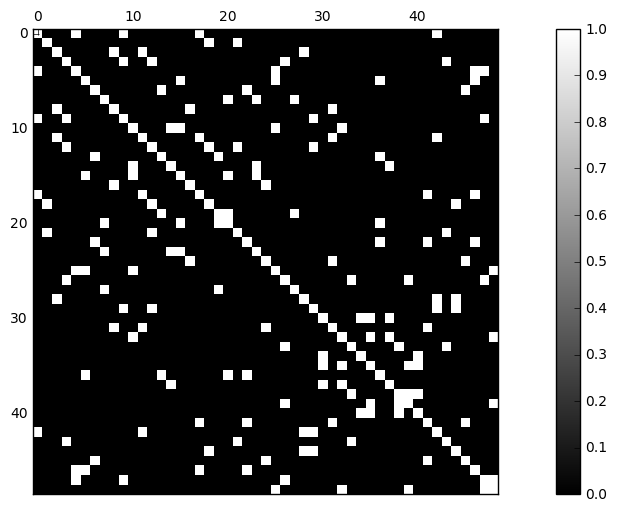

In [47]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(111)


cax = ax.matshow(np.sign(abs(Laplacian_perm)),  cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()

In [48]:
#n_iters = 20
precision_curve = []
recall_curve = []
avg_precision = []
auc_array = []
alpha_array = np.linspace(5e-2, 8e-1, n_iters)
max_iters = [1000]*n_iters #3 + [900]*2 + [400]*3
norm_diff= []
jaccard_sim_list = []
for i, alphas in enumerate(alpha_array):
    _, precision_em_o_tmp = \
                    latent_variable_glasso_data(X_o, X_h, alpha=alphas, mask=mask, max_iter_out = 1000, threshold=1e-2)
    norm_diff.append(graph_comparison_norm(Laplacian[np.ix_(observed_idx, observed_idx)], precision_em_o_tmp))                                           
    precision_curve_temp, recall_curve_temp, avg_precision_temp, auc_temp = \
                     graph_precision_recall_curve(Laplacian[np.ix_(observed_idx, observed_idx)], 
                                                     precision_em_o_tmp)
    jaccard_sim_list.append(jaccard_sim(edge_list_convert(Laplacian[np.ix_(observed_idx, observed_idx)]), \
                                        edge_list_convert(precision_em_o_tmp)))
    precision_curve.append(precision_curve_temp)
    recall_curve.append(recall_curve_temp)
    avg_precision.append(avg_precision_temp)
    auc_array.append(auc_temp)

  0%|          | 0/1000 [00:00<?, ?it/s]


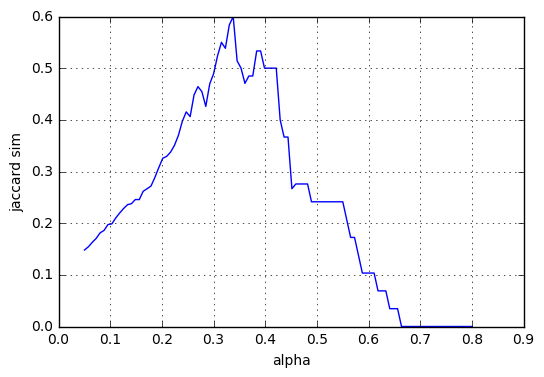

In [49]:
fig2 = plt.figure(2)
plt.plot(alpha_array, jaccard_sim_list, 'b')
plt.grid()
plt.xlabel('alpha')
plt.ylabel('jaccard sim')
plt.show()  
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_norm_diff.eps"
#if savefigure : fig2.savefig(filename)

In [50]:
#fig2 = plt.figure(2, figsize=(10,8))
#from itertools import cycle
#colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
#lw = 2
#for i, color in zip(range(n_iters), colors):
#    plt.plot(recall_curve[i], precision_curve[i], color=color, lw=lw, 
#             label='alpha = %.4f, AP = %.2f' % (alpha_array[i], avg_precision[i]))

#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.legend(loc="upper right")
#plt.show()  

In [51]:
#fig2 = plt.figure(2)
#plt.plot(alpha_array, norm_diff, 'b')
#plt.grid()
#plt.xlabel('lambda')
#plt.ylabel('relative error')
#plt.show()  
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_norm_diff_cvx.eps"
#if savefigure : fig2.savefig(filename)

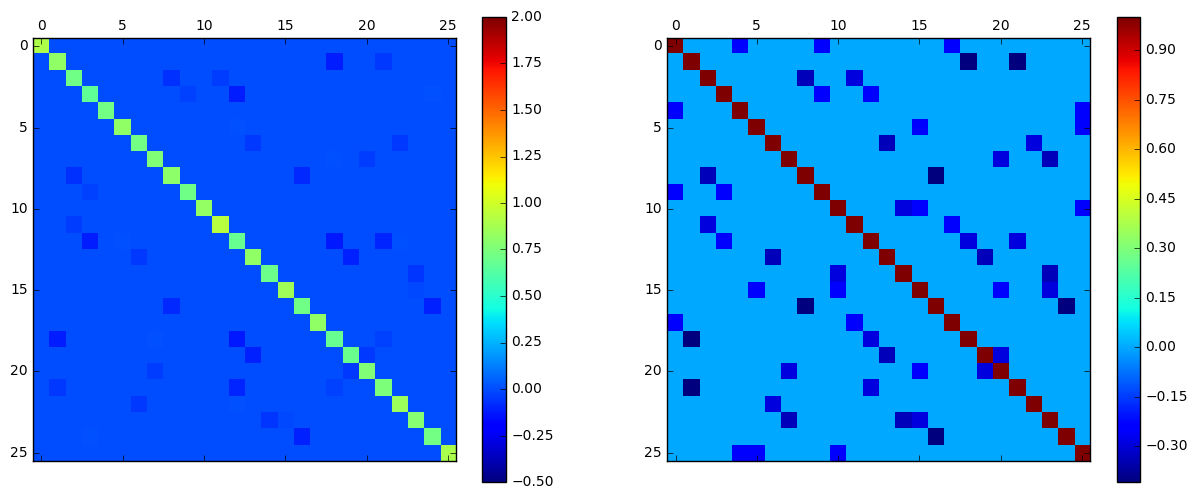

In [52]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(precision_em_o, vmin=-0.5, vmax=2)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)



cax = ax.matshow(Laplacian[np.ix_(observed_idx, observed_idx)])
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian_em.eps"
if savefigure : fig2.savefig(filename)

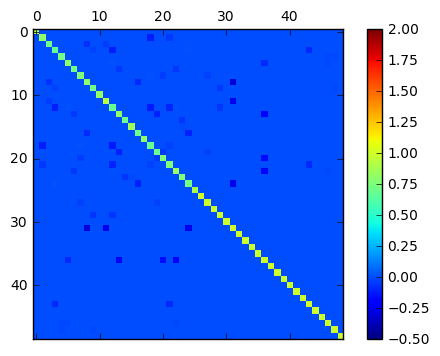

In [53]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[-1], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_noise_hidden.eps"
if savefigure : fig2.savefig(filename)

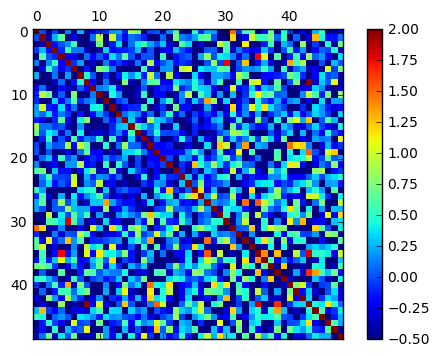

In [54]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[0], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_0.eps"
if savefigure : fig2.savefig(filename)

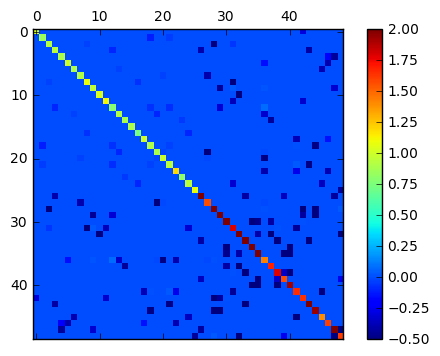

In [55]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[1],  vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_1.eps"
if savefigure : fig2.savefig(filename)

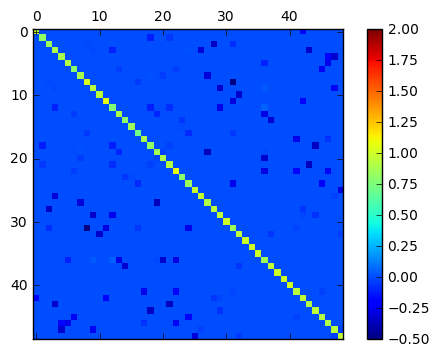

In [56]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[2], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_2.eps"
if savefigure : fig2.savefig(filename)

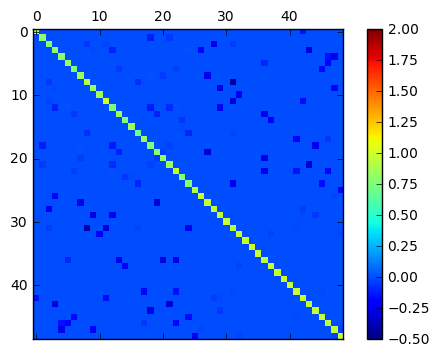

In [57]:
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[3], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_3.eps"
if savefigure : fig2.savefig(filename)

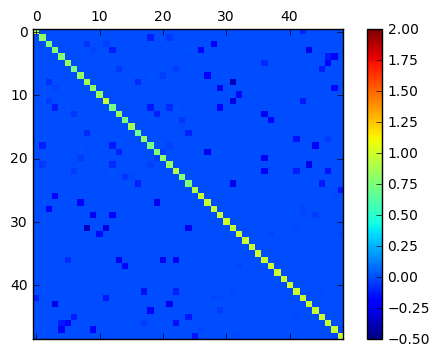

In [58]:
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[4], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_4.eps"
if savefigure : fig2.savefig(filename)

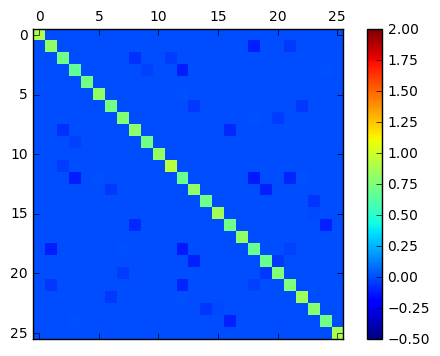

In [59]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(precision_em_o, vmin=-0.5, vmax=2)
fig2.colorbar(cax)


plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_o_em.eps"
if savefigure : fig2.savefig(filename)

##  Use cvx to learn the latent variable sparse inverse covariance estimation

\begin{eqnarray}
 (\mathbf{S}^{*} , \mathbf{L}^{*})&= \arg\min_{\mathbf{L}\;, \;\mathbf{S}} -\frac{m}{2}\log\det\left(\mathbf{S} - \mathbf{L}\right)+ \frac{m}{2}\text{tr}\left(\widehat{\mathbf{\Sigma} }_{o}\left( \mathbf{S} - \mathbf{L}\right)\right) + \alpha_{m} \left(\lambda \|\mathbf{S}\|_{1}  + \|\mathbf{L}\|_{*}\right)  \\
&\phantom{=}\text{s.t. }\quad \mathbf{S} - \mathbf{L}\succeq \mathbf{0} \nonumber\\
&\phantom{===}\; \mathbf{L}\succeq \mathbf{0}  \nonumber
\end{eqnarray}

In [60]:
#from latent_graphical_lasso import latent_variable_gmm_cvx
#import pywt

In [61]:
#alpha3 = 0.45
#sparse_cvx_o, low_rank_cvx_o = latent_variable_gmm_cvx(X_o, alpha=alpha3, lambda_s=0.3, verbose=True)

In [62]:
# plot the precision matrix and the support of Laplacian matrix
#fig2= plt.figure(2, figsize=(15,6))
#ax = fig2.add_subplot(121)
#cax = ax.matshow(sp.sign(abs(pywt.threshold(sparse_cvx_o, 1e-3, 'hard'))), cmap=plt.cm.gray)
#fig2.colorbar(cax)

#ax = fig2.add_subplot(122)
#cax = ax.matshow(sp.sign(abs((Laplacian[np.ix_(observed_idx, observed_idx)]))), cmap=plt.cm.gray)
#fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

#plt.show()
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian_cvx.eps"
#if savefigure : fig2.savefig(filename)

In [63]:
#n_iters = 8
#precision_curve = []
#recall_curve = []
#avg_precision = []
#auc_array = []
#lambda_array = np.linspace(1e-2, 1, n_iters)
#norm_diff = []
#for i, lambda_s in enumerate(lambda_array):
#    sparse_cvx_temp, low_rank_cvx_temp = latent_variable_gmm_cvx(X_o, alpha=0.1, lambda_s=lambda_s, verbose=True)
#    norm_diff.append(graph_comparison_norm(Laplacian[np.ix_(observed_idx, observed_idx)], 
#                                           pywt.threshold(sparse_cvx_temp, 1e-3, 'hard')))
#    precision_curve_temp, recall_curve_temp, avg_precision_temp, auc_temp = \
#                  graph_precision_recall_curve(Laplacian[np.ix_(observed_idx, observed_idx)], 
#                                               pywt.threshold(sparse_cvx_temp, 1e-3, 'hard'))
#    precision_curve.append(precision_curve_temp)
#    recall_curve.append(recall_curve_temp)
#    avg_precision.append(avg_precision_temp)
#    auc_array.append(auc_temp)

In [64]:
#from itertools import cycle
#fig2 = plt.figure(2, figsize=(10,8))
#colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
#lw = 2
#for i, color in zip(range(n_iters), colors):
#    plt.plot(recall_curve[i], precision_curve[i], color=color, lw=lw, 
#             label='alpha = %.2f, AP = %.2f' % (lambda_array[i], avg_precision[i]))

#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.legend(loc="upper right")
#plt.show()  
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_PRcurve_cvx.eps"
#if savefigure : fig2.savefig(filename)

See that the estimated precision matrix by latent-variable-gmm is not sparse. 